*This jupyter notebook is part of Arizona State University's course CAS 503 (Fundamentals of Complex Systems Science: Collectives) and was written by Bryan Daniels.  It was last updated September 2, 2024.*

#
#  Note: This is an example assignment and is not intended to be submitted.  
#  **Please do not turn in this notebook!**
# 

# Coarse graining concepts

To understand the emergent behavior of physical systems, like the hardness of a crystal of a trillion trillion carbon atoms, we have conceptual and mathematical tools that allow us to think about the behavior of an aggregate when we know how its constituent components behave.

The same concepts are useful in thinking about biological and social systems, too.  These systems typically have far fewer components (say, tens or hundreds to millions or billions).

In this demo, we will play with simulations of small systems to get an intuitive feel for these concepts.

## People wandering through a city

Imagine people moving through a city.

To make the point most simply, let's assume we have a bunch of wanderers who don't have a destination in mind.  (We will need more complicated tools when people have more complicated behavior---but the usefulness of the concept of coarse-graining will persist.)

Run the following code to set up the simulation.  (To run a cell in a jupyter notebook, highlight the cell and press shift-enter.)

In [102]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

def simulate2Ddiffusion(initialState, oneStepFunction, numTimesteps, seed=123):
    """
    Simulates a 2-dimensional diffusion process with particles moving at each timepoint from
    their current position to a new one according to a given single-step function.

    initialState        : an (N x 2) array representing the initial 2D positions of N particles
    oneStepFunction     : a function that acts on an (N x 2) array of positions to perform one simulation step
    numTimesteps        : the number of timesteps to simulate

    Returns:

    stateHistory        : a ((numTimesteps + 1) x N x 2) array containing the 2D positions of N particles
                          over time (including the initial state at t=0)
    """
    np.random.seed(seed)
    stateHistory = []
    currentState = np.copy(initialState)
    for i in range(numTimesteps + 1):
        stateHistory.append(currentState)
        currentState = oneStepFunction(currentState)
    return np.array(stateHistory)

def squareStep(state,width=1):
    """
    Takes a step randomly chosen within a square of given width.
    """
    step = width*(np.random.random(size=np.shape(state)) - 0.5)
    return state + step

def manhattanStep(state,stepsize=1):
    """
    Takes a step of given stepsize in a random cardinal direction (north, east, south, or west).
    """
    thetas = np.random.randint(0,4,size=len(state)) * np.pi/2.
    return np.transpose((state[:,0] + stepsize*np.cos(thetas),
                         state[:,1] + stepsize*np.sin(thetas)))

def diskStep(state,diameter=1):
    """
    Takes a step randomly within a disk of given diameter.
    """
    thetas = 2.*np.pi*np.random.random(size=len(state))
    rs = diameter/2. * np.random.random(size=len(state))
    return np.transpose((state[:,0] + rs*np.cos(thetas),
                         state[:,1] + rs*np.sin(thetas)))

def circleStep(state,diameter=1):
    """
    Takes a step of fixed size along a randomly chosen angle.
    """
    thetas = 2.*np.pi*np.random.random(size=len(state))
    rs = np.ones(len(state))
    return np.transpose((state[:,0] + rs*np.cos(thetas),
                         state[:,1] + rs*np.sin(thetas)))

def plotSteps(states,times,colors):
    """
    Given a history of states, plots the locations of particles at given times using given colors.
    """
    for t,color in zip(times,colors):
        plt.scatter(states[t,:,0],states[t,:,1],s=1,color=color)
        plt.axis('equal')
        plt.axis('off')

The simulation starts with a group of people at the same location.  Then each individual takes a step in a random direction.  The direction can be chosen in three ways:
* "Manhattan step": Each person walks one block in a random direction along streets in a square grid.
* "Disk step": Each person chooses a random direction not confined along streets and walks in that direction a random distance up to some maximum.
* "Circle step": Each person chooses a random direction not confined along streets and walks a fixed distance in that direction.

The following code runs the three cases with 2000 individuals taking a single step and plots the resulting positions.

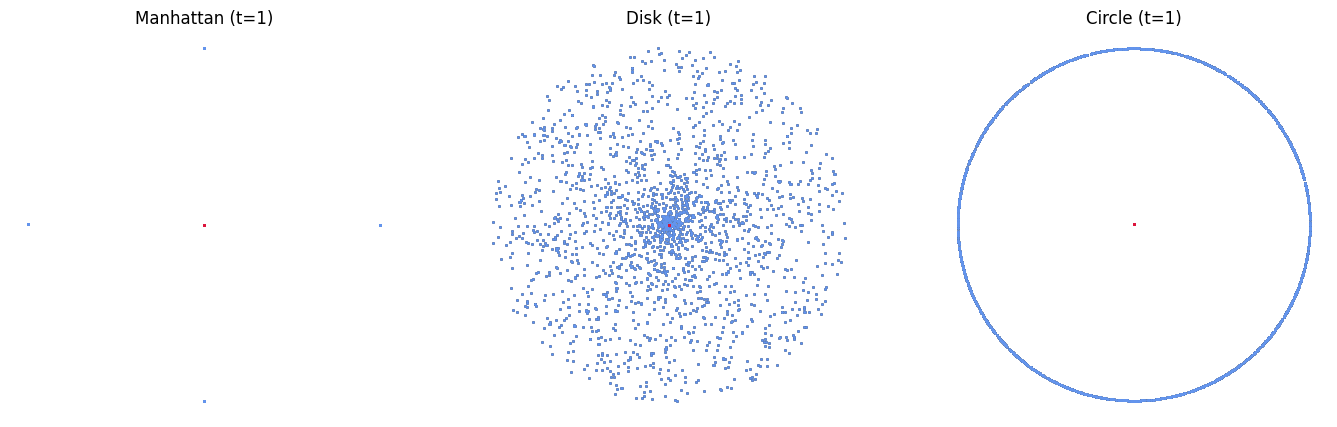

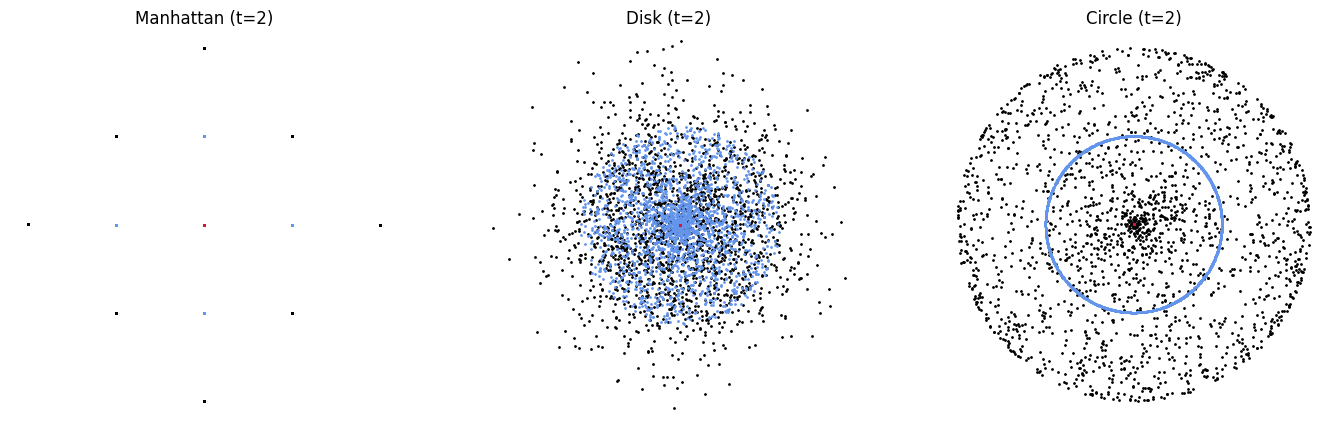

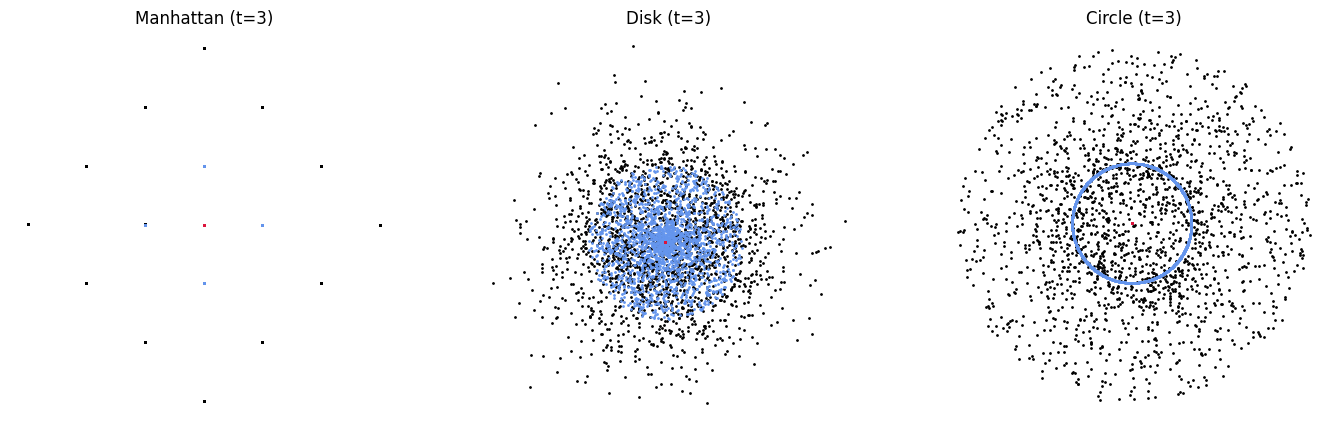

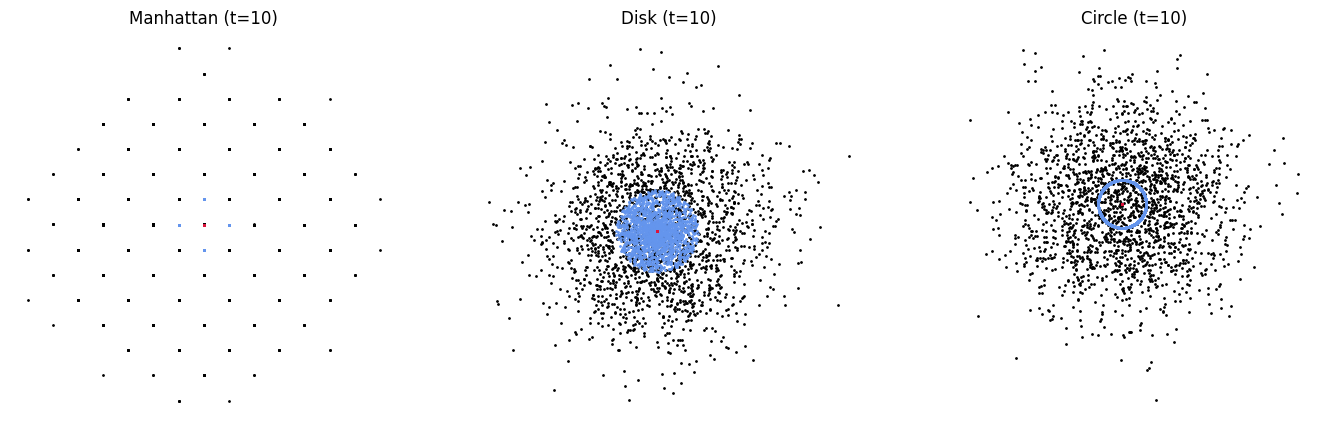

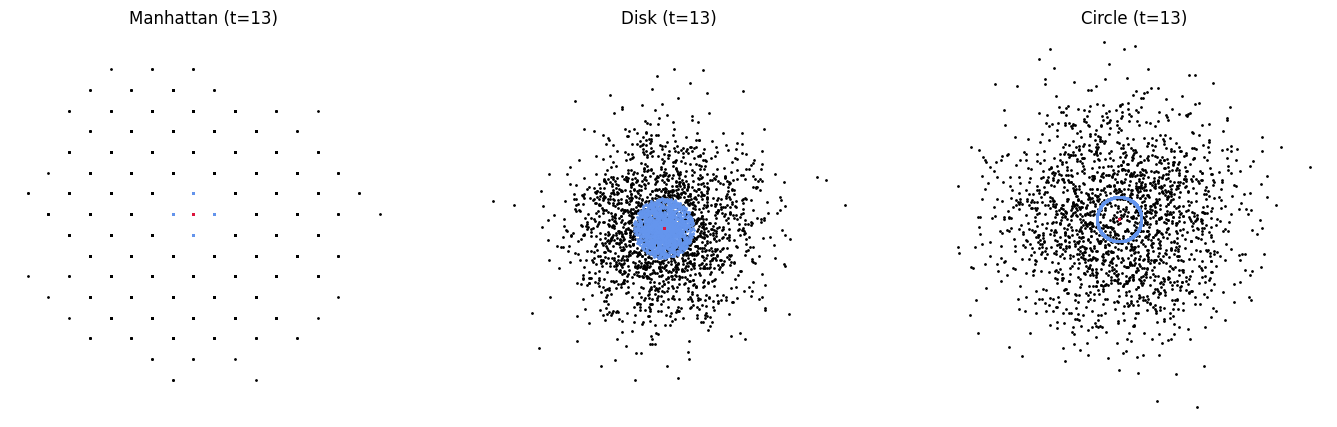

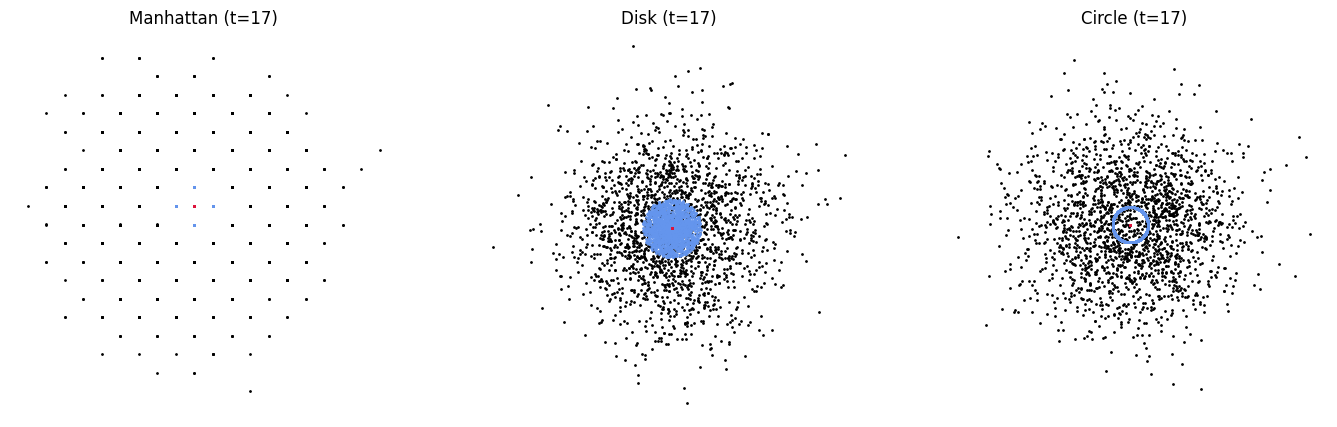

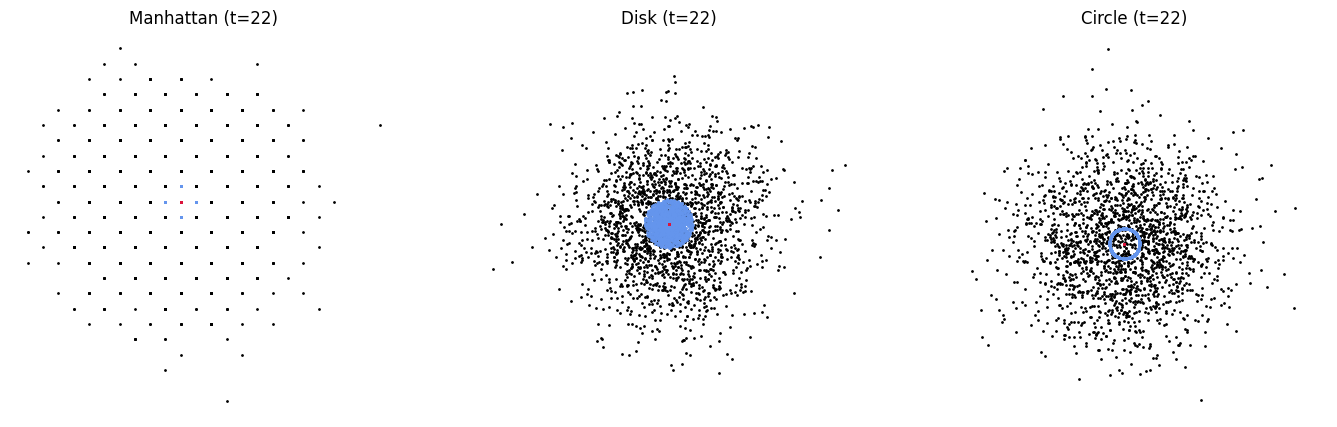

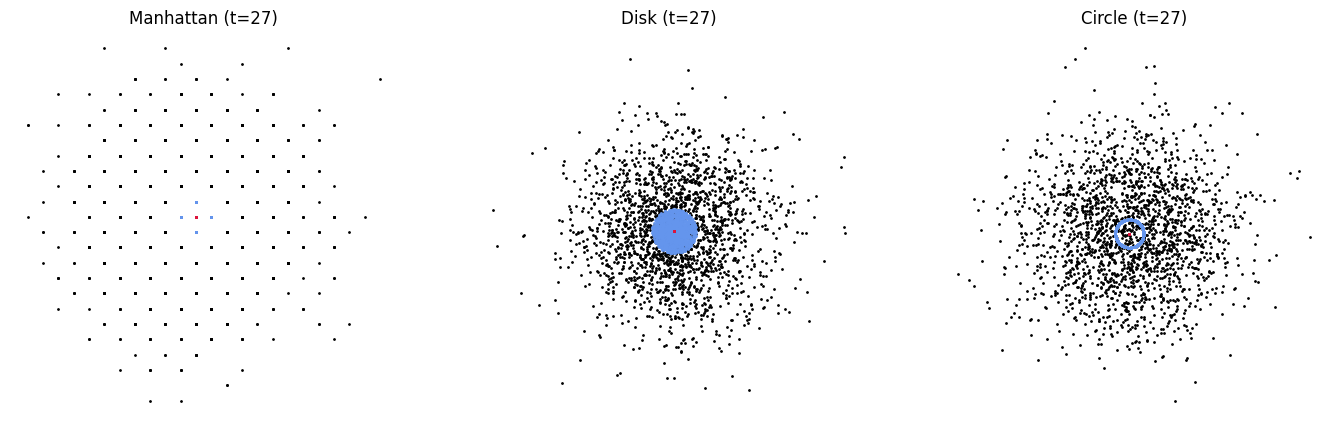

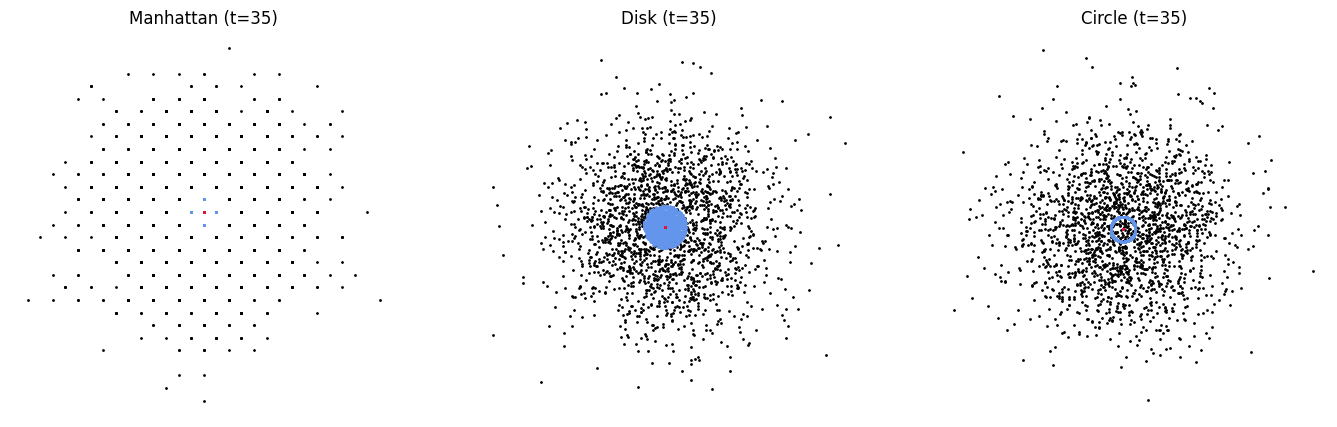

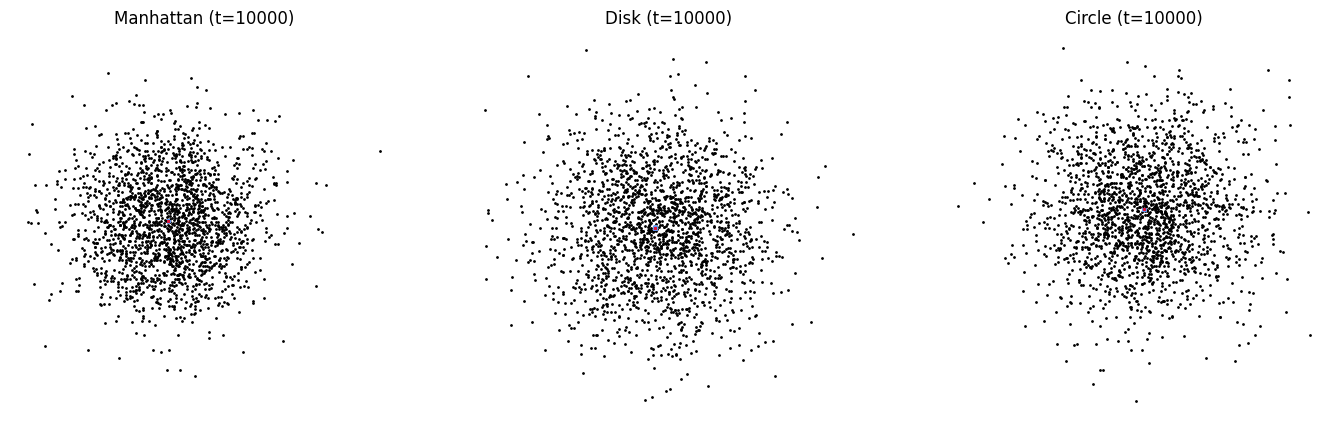

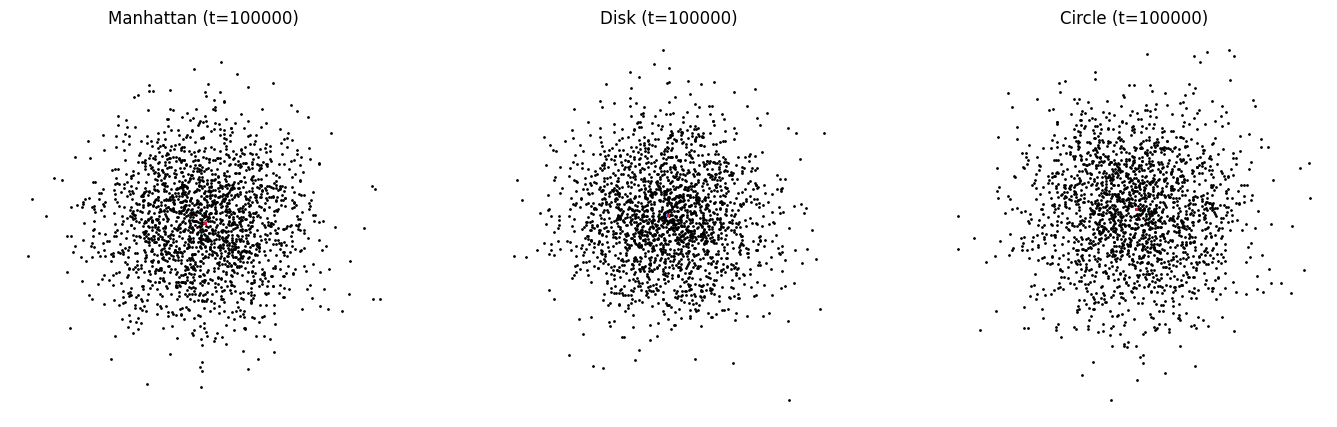

In [103]:
N = 2000  # number of individual people to simulate
numTimestepses = [1, 2, 3, 10, 13, 17, 22, 27, 35, 10000, 100000]  # number of timesteps to simulate

# initial locations: everyone starts at the origin
initialState = np.zeros((N, 2))


for numTimesteps in numTimestepses:
    # run the simulation for three types of steps: Manhattan, Disk, and Circle
    statesManhattan = simulate2Ddiffusion(initialState, manhattanStep, numTimesteps, seed=123)
    statesDisk = simulate2Ddiffusion(initialState, diskStep, numTimesteps, seed=126)
    statesCircle = simulate2Ddiffusion(initialState, circleStep, numTimesteps, seed=128)

    # plot positions at t=0 (crimson), t=1 (cornflowerblue), and t=numTimesteps (black)
    plt.figure(figsize=(17, 5))
    for i, states, name in zip(
        range(3),
        [statesManhattan, statesDisk, statesCircle],
        ["Manhattan", "Disk", "Circle"],
    ):
        plt.subplot(1, 3, i + 1)
        plotSteps(states, [numTimesteps, 1, 0], ["black", "cornflowerblue", "crimson"])
        plt.title(f"{name} (t={numTimesteps})")

Run the code again using `numTimesteps = 2`.  Now the code plots the places where people end up after 1 step in blue, and after 2 steps in black.  ❓**How would you describe the distribution of people after 2 steps in the three cases?  Are patterns visible?**

✳️ **Answer:** Ah! Circle is indeed rather lovely, isn't it? Here are the things I would like to define:

- What do we call a simulation whose first step is predictable but then whose second step is not, even though the *rule itself does not change*?
- Can we formalize a name for the 2nd step? As in, this simulation has a predictability depth of $/tau$? (Or whatever variable.)
- Can we find other simulations with larger values for /$tau$?

Meanwhile, Manhattan is tiling (also cool but not so mind blowing. But, related in a way?)

Disk is diffuse? There's a stippling effect related to probability.

We should measure the entropy at each step for each simulation type.

Let's see about the "official" exercises, and we'll come back to this.

Now increase the number of timesteps above from 2 to 10 and rerun the simulation.  The plotting routine will automatically zoom out to show all the final points.

Now increase the number of timesteps further, up to 10000 (or more if you are willing to wait!).  ❓**How many numbers do we need to describe the emergent, coarse-grained characteristics of the movement when we zoom out to many steps?** 

✳️ **Answer:**  I only went to 10 steps.

We can show this more precisely by estimating the *probability density*—that is, after they have roamed for some time, how likely are we to find a person on any given patch of land?  

The function `plt.hist` takes a list of values and plots a histogram showing the number of samples per bin.  ❓**Use `plt.hist` to plot a histogram of final horizontal positions after a long time has passed for each type of step.  Use `plt.xlabel` and `plt.ylabel` to label the axes appropriately.  Use `plt.title` to give each plot a title with the name of the step type.**

In [104]:
# ✳️ Answer:

These three plots look quite similar, though the scale is different: Manhattan walkers end up further from their starting point than Disk walkers.  What if we rescale by this single parameter?  Do we end up converging toward a single emergent distribution shape?

❓**Use `plt.hist` to plot all three histograms on the same figure, also dividing the horizontal positions by the width of the distribution in each case, as measured by the standard deviation (`np.std`).**  *Hints: When comparing multiple histograms, it is useful to use a consistent set of bins (specify the bins defined by the code below by passing `bins=bins` to `plt.hist`).  The `histtype='step'` option will useful to show the histogram shapes without overlapping.  I've done the first for you.*

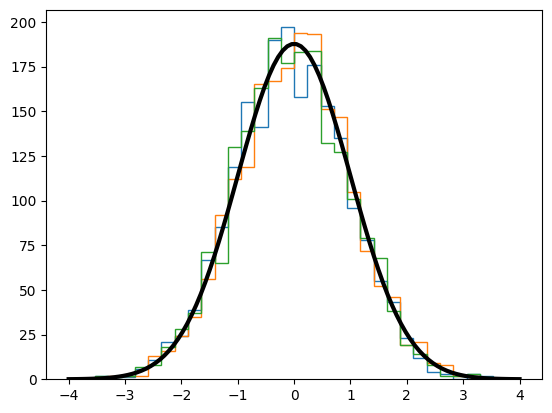

In [105]:
numBins = 35
minx,maxx = -4,4
bins = np.linspace(minx,maxx,numBins)

plt.hist(statesManhattan[numTimesteps,:,0]/np.std(statesManhattan[numTimesteps,:,0]),histtype='step',bins=bins);
plt.hist(statesDisk[numTimesteps,:,0]/np.std(statesDisk[numTimesteps,:,0]),histtype='step',bins=bins);
plt.hist(statesCircle[numTimesteps,:,0]/np.std(statesCircle[numTimesteps,:,0]),histtype='step',bins=bins);
x = np.linspace(bins[0],bins[-1],100)
binwidth = bins[1]-bins[0]
plt.plot(x,N*binwidth*scipy.stats.norm.pdf(x),'k-',lw=3)


In [106]:
# ✳️ Answer:

The statistically inclined among you will recognize this as a normal (Gaussian) distribution.  ❓**Use the following code to add the predicted normal distribution to your plot.**

In [107]:
# ✳️ Answer: I did that.

The moral of the story: If we care only about the behavior of walkers over a long time, many details about the small-scale behavior average out and become unimportant.  In this case, the single detail that survives is the average speed of the walker (setting the width of the eventual distribution of possible positions).  

For this reason, even if we know that walkers are, say, confined to streets, we might choose to model their behavior more simply as "Take a bunch of steps in random directions with equal size".  In fact, in this simple case, we can derive the form of the final distribution analytically and do not need to simulate at all!

## Particles with gravity and nearest neighbor interactions

Go to the [LiquidFun simulation website](https://google.github.io/liquidfun/testbed/).